In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import pyplot


from copy import deepcopy

from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV


# 1) Loading in the merged data and droping rows containing null values

In [52]:
# Read data from merged_data.csv file
data_init = pd.read_csv("Data/merged_data.csv")
print("Number of rows that contain NaN: " + str(np.count_nonzero(data_init.isnull())))   
# Drop rows where any value is null
data = data_init.dropna(axis=0)
data.describe()

Number of rows that contain NaN: 16


,mortality_rate,medical_doctors,hospital_beds,Pharmacists,Che
count,908.000000,908.000000,908.00000,908.000000,908.000000
mean,127.705947,25.914464,45.98304,5.074839,1707.823128
std,67.796818,10.952747,26.41928,3.527541,2038.839974
min,49.000000,0.231000,0.10000,0.003000,6.000000
25%,76.000000,19.447000,26.07500,1.919250,216.825000
50%,104.000000,26.749000,40.70000,5.260500,803.750000
75%,160.000000,33.842500,64.72500,7.165250,2577.025000
max,469.000000,70.946000,139.70000,18.017000,10014.700000


<AxesSubplot:>

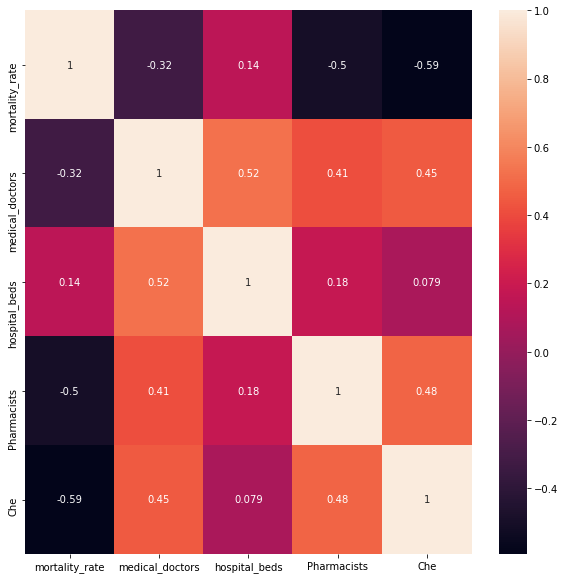

In [36]:
fig, ax= pyplot.subplots(figsize=(10,10))
sns.heatmap(data.corr(),annot=True)

# 2) Creating classes according to intervals for the mortality


In [37]:
# Creating classes for mortality by discretizing the mortality_rate data
discretize = lambda x : "low" if x < 80 else "average" if x < 200 else "high" if x < 325 else "highest"
data.loc[:, "mortality_rate"] = data.loc[:, "mortality_rate"].map(discretize)


<AxesSubplot:xlabel='mortality_rate', ylabel='count'>

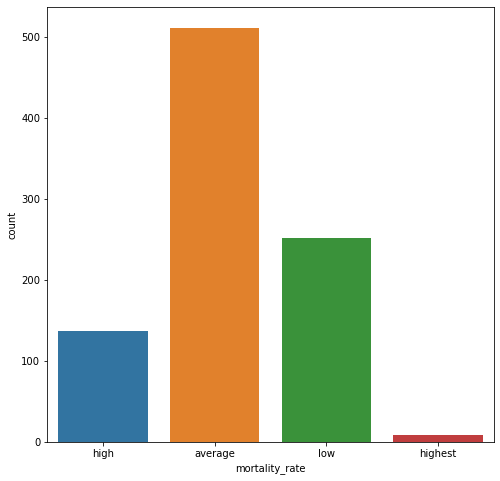

In [38]:
fig, ax= pyplot.subplots(figsize=(8,8))
sns.countplot(x=data['mortality_rate'],ax=ax)

# 3) Splitting in X, y data and training, testing sets

In [15]:
# Data splitting into training and testing sets
data_X = data.drop(data.columns[[0, 1, 2]], axis=1)
data_y = data.drop(data.columns[[0, 1, 3, 4, 5, 6]], axis=1)
data_y.head(15)

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(data_X, np.ravel(data_y), test_size=.20, shuffle=True)


# 4) Model selection

## 4.1 k-nn parameters

In [5]:
# k-nn parameters
parameters = { 'n_neighbors': range(3, 100) }
clf = GridSearchCV(KNeighborsClassifier(), parameters, n_jobs=4)
clf.fit(X=X_train, y=y_train)
knn_model = clf.best_estimator_
print ("Testing accuracy: {0} \nBest parameters: {1} ".format(clf.best_score_, clf.best_params_))
print("Training accuracy:",clf.score(X_train,y_train))

0.754822862541332 {'n_neighbors': 8}


## 4.2 Decision tree parameters

In [6]:
parameters = { 'criterion': ['gini', 'entropy'], 
              'max_depth': range(1, 100), 
              'min_samples_split': range(2, 10) }

print("Evaluating decision tree parameters...")
clf = GridSearchCV(DecisionTreeClassifier(), parameters, n_jobs=4)
clf.fit(X=X_train, y=y_train)
tree_model = clf.best_estimator_
print ("Testing accuracy: {0} \nBest parameters: {1} ".format(clf.best_score_, clf.best_params_))
print("Training accuracy:",clf.score(X_train,y_train))

Evaluating decision tree parameters...
0.8829192253188476 {'criterion': 'entropy', 'max_depth': 78, 'min_samples_split': 2}


## 4.3 SVC parameters

In [7]:
parameters = { 'C': np.linspace(start=0.1, stop=1, num=20),
              'kernel': ['poly', 'rbf', 'sigmoid'],
              'shrinking': [True, False]
             }

print("Evaluating SVC parameters...")
clf = GridSearchCV(SVC(), parameters, n_jobs=8)
clf.fit(X=X_train, y=y_train)
svc_model = clf.best_estimator_
print ("Testing accuracy: {0} \nBest parameters: {1} ".format(clf.best_score_, clf.best_params_))
print("Training accuracy:",clf.score(X_train,y_train))

Evaluating SVC parameters...
0.7051771374586678 {'C': 0.9052631578947369, 'kernel': 'rbf', 'shrinking': True}


## 4.4 NN parameters

In [ ]:
small = (8, 8, 8)
medium = (8, 16, 32, 16, 8)
large = (32, 64, 128, 256, 128, 64, 32)
very_large = (64, 128, 256, 512, 512, 512, 256, 128, 64)

networks = [ small, medium, large, very_large ]
parameters = {'hidden_layer_sizes': networks}

clf = GridSearchCV(MLPClassifier(), parameters, n_jobs=4)
clf.fit(X=X_train, y=y_train)
nn_model = clf.best_estimator_
print ("Testing accuracy: {0} \nBest parameters: {1} ".format(clf.best_score_, clf.best_params_))
print("Training accuracy:",clf.score(X_train,y_train))

## 4.5 Cross-validation and model selection

In [9]:
# Different classifiers for cross-validation
bayes_model = GaussianNB()

# Creating list of clasifiers
classifier_list = [knn_model, bayes_model, tree_model, svc_model, nn_model]
best_model = []
test_averages = []

# Iterating over classifiers
for classifier in classifier_list: 
    scores = cross_validate(classifier, X_train, y_train, scoring="accuracy", return_train_score=True, return_estimator=True)
    best_model.append(deepcopy(scores["estimator"][np.argmax(scores["train_score"])]))


# 5) Testing and results


In [10]:
# Array to add all test scores obtain using predict method of each classifier.
# In order K-Neighbors Classifier, Bayesian Classifier, Decision Tree Classifier, Support Vector Machine Classifier and Multi Layer Perceptron Classifier
test_scores = [] 

# Iterating over best models obtained by crossvalidation
for model in best_model:
    y_pred = model.predict(X_test)
    test_scores.append(accuracy_score(y_test, y_pred))

print(test_scores)

[0.6813186813186813, 0.5659340659340659, 0.7747252747252747, 0.6373626373626373, 0.7362637362637363]
